In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone NCAA Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Capstone NCAA Project


## Data Preparation

### Team ID

In [3]:
team_ids = pd.read_csv("data/2022_Stage1/MTeams.csv")
team_ids = team_ids[["TeamID", "TeamName"]]
team_ids

,TeamID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M
...,...,...
367,1468,Bellarmine
368,1469,Dixie St
369,1470,Tarleton St
370,1471,UC San Diego


### Seeds

In [4]:
df_seeds = pd.read_csv("data/2022_Stage1/MNCAATourneySeeds.csv")
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### Regular Season Results

In [5]:
df_season_results = pd.read_csv("data/2022_Stage1/MRegularSeasonCompactResults.csv")
df_season_results.drop(['WLoc', 'NumOT'], axis=1, inplace=True)

In [6]:
df_season_results['ScoreDiff'] = df_season_results['WScore'] - df_season_results['LScore']
df_season_results = df_season_results[df_season_results['Season'] >= 2002].reset_index(drop=True)

In [7]:
df_season_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreDiff
0,2002,10,1112,71,1268,67,4
1,2002,10,1196,72,1396,64,8
2,2002,11,1112,75,1196,71,4
3,2002,11,1268,82,1396,74,8
4,2002,14,1116,64,1263,47,17
...,...,...,...,...,...,...,...
104973,2022,98,1400,79,1242,76,3
104974,2022,98,1411,66,1126,63,3
104975,2022,98,1422,68,1441,49,19
104976,2022,98,1438,69,1181,68,1


### Tournamet Results

In [8]:
df_tourney_results = pd.read_csv("data/2022_Stage1/MNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
#Remove results before 2002 since Pomeroy ratings don't start until 2002
df_tourney_results = df_tourney_results[df_tourney_results['Season'] >= 2002].reset_index(drop=True)
df_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2002,134,1373,81,1108,77
1,2002,136,1104,86,1194,78
2,2002,136,1112,86,1364,81
3,2002,136,1181,84,1457,37
4,2002,136,1231,75,1428,56
...,...,...,...,...,...,...
1240,2021,148,1211,85,1425,66
1241,2021,148,1417,51,1276,49
1242,2021,152,1124,78,1222,59
1243,2021,152,1211,93,1417,90


### Pomeroy Ratings

In [9]:
df_pomeroy = pd.read_csv("data/pomeroy_data.csv")
df_pomeroy.rename(columns={'Team': 'TeamName'}, inplace=True)
df_pomeroy = df_pomeroy.drop(['Unnamed: 0', "W-L", "Conf", "Seed"], axis=1)
team_ids_pomeroy = team_ids.copy()
df_pomeroy_nan = df_pomeroy.merge(team_ids_pomeroy, on=['TeamName'], how='outer')

In [10]:
teamId_nan = df_pomeroy_nan[df_pomeroy_nan['TeamID'].isna()]
nan_teams_pomeroy = teamId_nan["TeamName"].unique()
nan_teams_pomeroy = sorted(nan_teams_pomeroy)

In [11]:
indexes_to_change_pomeroy = [0,5,6,7,9,10,12,13,14,25,28,30,66,67,68,47,40,48,55,56,57,60,63,74,89,83,85,91,93,94,98,100,102,103,108,352,135,126,128,131,134,137,139,142,144,152,317,159,169,176,191,353,179,189,182,183,185,186,187,190,192,200,207,212,198,199,194,193,196,221,225,228,232,235,239,240,285,286,287,288,257,260,265,253,254,267,279,255,281,282,283,284,271,293,310,326,328,349,350,342,343,354,359]
for i in range(len(indexes_to_change_pomeroy)):
    team_ids_pomeroy.at[indexes_to_change_pomeroy[i],"TeamName"] = nan_teams_pomeroy[i]

In [12]:
df_pomeroy = df_pomeroy.merge(team_ids_pomeroy, on=['TeamName'], how='right')
df_pomeroy = df_pomeroy.dropna()

In [13]:
df_pomeroy["Year"] = df_pomeroy["Year"].astype(int)
df_pomeroy["AdjO Rank"] = df_pomeroy["AdjO Rank"].astype(int)
df_pomeroy["AdjD Rank"] = df_pomeroy["AdjD Rank"].astype(int)
df_pomeroy["AdjT Rank"] = df_pomeroy["AdjT Rank"].astype(int)
df_pomeroy["Luck Rank"] = df_pomeroy["Luck Rank"].astype(int)
df_pomeroy["AdjEM Rank"] = df_pomeroy["AdjEM Rank"].astype(int)
df_pomeroy["OppO Rank"] = df_pomeroy["OppO Rank"].astype(int)
df_pomeroy["OppD Rank"] = df_pomeroy["OppD Rank"].astype(int)
df_pomeroy["AdjEM Rank.1"] = df_pomeroy["AdjEM Rank.1"].astype(int)
df_pomeroy = df_pomeroy.rename(columns={"Year": "Season",
                                        "AdjO": "AdjO Eff",
                                        "AdjO Rank": "AdjO Eff Rank",
                                        "AdjD": "AdjD Eff",
                                        "AdjD Rank": "AdjD Eff Rank",
                                        "AdjT": "AdjTempo",
                                        "AdjT Rank": "AdjTempo Rank",
                                        "AdjEM.1": "Opp AdjEM",
                                        "AdjEM Rank": "Opp AdjEM Rank",
                                        "AdjEM.2": "NCSOS AdjEM",
                                        "AdjEM Rank.1": "NCSOS AdjEM Rank"})

In [14]:
df_pomeroy

,Rk,TeamName,AdjEM,AdjO Eff,AdjO Eff Rank,AdjD Eff,AdjD Eff Rank,AdjTempo,AdjTempo Rank,Luck,...,Opp AdjEM,Opp AdjEM Rank,OppO,OppO Rank,OppD,OppD Rank,NCSOS AdjEM,NCSOS AdjEM Rank,Season,TeamID
0,152.0,Abilene Christian,1.35,103.4,196,102.0,121,66.1,256,0.123,...,-8.67,341,100.0,326,108.7,336,-4.75,295,2019,1101
1,84.0,Abilene Christian,10.11,101.7,184,91.6,26,69.3,115,0.009,...,-5.43,298,99.4,287,104.8,300,4.93,137,2021,1101
2,36.0,Air Force,15.42,111.4,47,96.0,43,51.9,326,0.025,...,0.58,143,103.3,170,102.8,138,-10.49,318,2004,1102
3,40.0,Air Force,14.87,113.2,21,98.3,89,54.7,332,-0.001,...,0.57,147,102.8,176,102.2,137,-6.63,300,2006,1102
4,20.0,Air Force,20.20,116.5,20,96.3,45,57.5,332,-0.021,...,3.24,99,106.5,95,103.2,117,-1.91,200,2007,1102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,15.0,Xavier,21.51,120.1,8,98.6,57,70.5,62,0.091,...,9.35,35,109.9,37,100.6,29,1.84,108,2018,1462
1874,65.0,Xavier,10.60,111.1,56,100.5,102,65.2,302,-0.004,...,7.48,55,108.7,45,101.2,61,1.04,124,2019,1462
1875,47.0,Yale,14.33,110.4,88,96.0,34,66.0,275,0.026,...,-0.85,169,105.5,122,106.4,209,-1.00,193,2016,1463
1876,77.0,Yale,8.79,111.6,51,102.8,141,71.0,41,0.041,...,-1.10,167,103.0,224,104.2,140,-2.09,222,2019,1463


### Betting Odds Data

In [15]:
betting_odds_df = pd.read_csv("data/betting_data//betting_data.csv")
betting_odds_df = betting_odds_df.drop(['Unnamed: 0'], axis=1)
betting_odds_df["Championship Win Probability"] = 100 / (betting_odds_df["Round 1 Odds"].str[1:].astype(int) + 100)
betting_odds_df = betting_odds_df.rename(columns={"Team": "TeamName", "Year": "Season", "Round 1 Odds": "Championship Moneyline Odds Before Round 1"})
betting_odds_df["TeamName"] = betting_odds_df["TeamName"].str.strip()
betting_odds_df = betting_odds_df[betting_odds_df["TeamName"] != "FIELD"]

In [16]:
team_ids_betting_odds = team_ids.copy()
df_betting_nan = betting_odds_df.merge(team_ids_betting_odds, on=['TeamName'], how='outer')

In [17]:
teamId_nan = df_betting_nan[df_betting_nan['TeamID'].isna()]
nan_teams_betting = teamId_nan["TeamName"].unique()
nan_teams_betting = sorted(nan_teams_betting)

In [18]:
indexes_to_change_betting = [0,5,6,9,10,12,13,26,28,30,30,67,47,315,40,57,55,56,60,63,74,89,83,85,91,93,94,98,100,104,102,108,352,126,131,134,137,139,142,144,152,153,317,159,169,173,174,176,191,353,179,189,183,185,186,187,190,192,322,207,212,194,193,196,221,225,228,178,232,235,234,239,240,257,260,262,253,254,267,279,255,285,287,288,271,271,293,293,326,310,306,168,320,325,328,349,350,342,343,354,356,359]
for i in range(len(indexes_to_change_betting)):
    team_ids_betting_odds.at[indexes_to_change_betting[i],"TeamName"] = nan_teams_betting[i]

In [19]:
betting_odds_df = betting_odds_df.merge(team_ids_betting_odds, on=['TeamName'], how='right')
betting_odds_df = betting_odds_df.dropna()
betting_odds_df

,TeamName,Championship Moneyline Odds Before Round 1,Season,Championship Win Probability,TeamID
0,Abilene Christian,+500000,2019.0,0.000200,1101
1,Abilene Christian,+100000,2021.0,0.000999,1101
2,Air Force,+75000,2004.0,0.001332,1102
3,Air Force,+50000,2006.0,0.001996,1102
4,Akron,+250000,2009.0,0.000400,1103
...,...,...,...,...,...
1336,Xavier,+52000,2017.0,0.001919,1462
1337,Xavier,+2450,2018.0,0.039216,1462
1338,Yale,+100000,2016.0,0.000999,1463
1339,Yale,+150000,2019.0,0.000666,1463


## Game Result Engineering

For each team for each season, we need to compute:

<li>Number of wins</li>
<li>Number of losses</li>
<li>Average margin of victory</li>
<li>Average margin of losses</li>

In order to calculate the following features: 
<li>Win Percentage</li>
<li>Average margin of victory/loss</li>

In [20]:
win_count = df_season_results.groupby(['Season', 'WTeamID']).count()
win_count = win_count.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "WinCount", "WTeamID": "TeamID"})
win_count

,Season,TeamID,WinCount
0,2002,1102,9
1,2002,1103,9
2,2002,1104,26
3,2002,1105,15
4,2002,1106,18
...,...,...,...
7199,2022,1468,9
7200,2022,1469,7
7201,2022,1470,8
7202,2022,1471,8


In [21]:
loss_count = df_season_results.groupby(['Season', 'LTeamID']).count()
loss_count = loss_count.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "LossCount", "LTeamID": "TeamID"})
loss_count

,Season,TeamID,LossCount
0,2002,1102,19
1,2002,1103,21
2,2002,1104,7
3,2002,1105,10
4,2002,1106,11
...,...,...,...
7205,2022,1468,11
7206,2022,1469,12
7207,2022,1470,13
7208,2022,1471,12


In [22]:
win_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
win_margin = win_margin[['Season', 'WTeamID', 'ScoreDiff']].rename(columns={"ScoreDiff": "AverageWinMargin", "WTeamID": "TeamID"})
win_margin

,Season,TeamID,AverageWinMargin
0,2002,1102,6.888889
1,2002,1103,8.111111
2,2002,1104,15.923077
3,2002,1105,15.266667
4,2002,1106,9.222222
...,...,...,...
7199,2022,1468,10.666667
7200,2022,1469,11.428571
7201,2022,1470,11.125000
7202,2022,1471,10.125000


In [23]:
loss_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
loss_margin = loss_margin[['Season', 'LTeamID', 'ScoreDiff']].rename(columns={"ScoreDiff": "AverageLossMargin", "LTeamID": "TeamID"})
loss_margin

,Season,TeamID,AverageLossMargin
0,2002,1102,9.421053
1,2002,1103,10.904762
2,2002,1104,12.142857
3,2002,1105,11.700000
4,2002,1106,12.727273
...,...,...,...
7205,2022,1468,16.545455
7206,2022,1469,19.333333
7207,2022,1470,11.769231
7208,2022,1471,13.416667


In [24]:
df_features_season_wins = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_wins

,Season,TeamID
0,2002,1102
1,2002,1103
2,2002,1104
3,2002,1105
4,2002,1106
...,...,...
7199,2022,1468
7200,2022,1469
7201,2022,1470
7202,2022,1471


In [25]:
df_features_season_losses = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})
df_features_season_losses

,Season,TeamID
0,2002,1102
1,2002,1103
2,2002,1104
3,2002,1105
4,2002,1106
...,...,...
7205,2022,1468
7206,2022,1469
7207,2022,1470
7208,2022,1471


In [26]:
df_features_season = pd.concat([df_features_season_wins, df_features_season_losses], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [27]:
#Join all of the dataframes into one dataframe
df_features_season = df_features_season.merge(win_count, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(loss_count, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(win_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(loss_margin, on=['Season', 'TeamID'], how='left')
df_features_season.fillna(0, inplace=True)  
df_features_season

,Season,TeamID,WinCount,LossCount,AverageWinMargin,AverageLossMargin
0,2002,1102,9.0,19.0,6.888889,9.421053
1,2002,1103,9.0,21.0,8.111111,10.904762
2,2002,1104,26.0,7.0,15.923077,12.142857
3,2002,1105,15.0,10.0,15.266667,11.700000
4,2002,1106,18.0,11.0,9.222222,12.727273
...,...,...,...,...,...,...
7208,2022,1468,9.0,11.0,10.666667,16.545455
7209,2022,1469,7.0,12.0,11.428571,19.333333
7210,2022,1470,8.0,13.0,11.125000,11.769231
7211,2022,1471,8.0,12.0,10.125000,13.416667


In [28]:
#Calculate win percentage from win and loss count
df_features_season['WinPercentage'] = df_features_season['WinCount'] / (df_features_season['WinCount'] + df_features_season['LossCount'])

In [29]:
#Calculate average margin of victory/defeat 
df_features_season['GapAvg'] = (
    (df_features_season['WinCount'] * df_features_season['AverageWinMargin'] - 
    df_features_season['LossCount'] * df_features_season['AverageLossMargin'])
    / (df_features_season['WinCount'] + df_features_season['LossCount'])
)

In [30]:
#Drop values we dont need after calculating win percentage and average margin of victory/defeat
df_features_season.drop(['WinCount', 'LossCount', 'AverageWinMargin', 'AverageLossMargin'], axis=1, inplace=True)

## Feature Engineering

### Training Data

In [31]:
df = df_tourney_results.copy()
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2002,134,1373,81,1108,77
1,2002,136,1104,86,1194,78
2,2002,136,1112,86,1364,81
3,2002,136,1181,84,1457,37
4,2002,136,1231,75,1428,56
...,...,...,...,...,...,...
1240,2021,148,1211,85,1425,66
1241,2021,148,1417,51,1276,49
1242,2021,152,1124,78,1222,59
1243,2021,152,1211,93,1417,90


In [32]:
#Add SeedW column
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})


In [33]:
#Add SeedL column
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})


In [34]:
#Remove region and play in tournament marker from seed (Convert seed into ints)
def seed_string_to_int(seed):
    return int(re.sub("[^0-9]", "", seed))

In [35]:
df['SeedW'] = df['SeedW'].apply(seed_string_to_int)
df['SeedL'] = df['SeedL'].apply(seed_string_to_int)

In [36]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2002,134,1373,81,1108,77,16,16
1,2002,136,1104,86,1194,78,2,15
2,2002,136,1112,86,1364,81,3,14
3,2002,136,1181,84,1457,37,1,16
4,2002,136,1231,75,1428,56,5,12
...,...,...,...,...,...,...,...,...
1240,2021,148,1211,85,1425,66,1,6
1241,2021,148,1417,51,1276,49,11,1
1242,2021,152,1124,78,1222,59,1,2
1243,2021,152,1211,93,1417,90,1,11


In [37]:
#Add WinPercentageW and GapAvgW columns
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinCount': 'WinCountW',
    'LossCount': 'LossCountW',
    'AverageWinMargin': 'AverageWinMarginW',
    'AverageLossMargin': 'AverageLossMarginW',
    'WinPercentage': 'WinPercentageW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [38]:
#Add WinPercentageL and GapAvgL columns
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinCount': 'WinCountL',
    'LossCount': 'LossCountL',
    'AverageWinMargin': 'AverageWinMarginL',
    'AverageLossMargin': 'AverageLossMarginL',
    'WinPercentage': 'WinPercentageL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

In [39]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinPercentageW,GapAvgW,WinPercentageL,GapAvgL
0,2002,134,1373,81,1108,77,16,16,0.470588,1.352941,0.689655,3.137931
1,2002,136,1104,86,1194,78,2,15,0.787879,9.969697,0.642857,1.714286
2,2002,136,1112,86,1364,81,3,14,0.709677,5.129032,0.655172,5.965517
3,2002,136,1181,84,1457,37,1,16,0.906250,19.937500,0.576923,3.538462
4,2002,136,1231,75,1428,56,5,12,0.633333,7.266667,0.703704,6.407407
...,...,...,...,...,...,...,...,...,...,...,...,...
1240,2021,148,1211,85,1425,66,1,6,1.000000,23.000000,0.758621,9.655172
1241,2021,148,1417,51,1276,49,11,1,0.653846,4.346154,0.833333,10.875000
1242,2021,152,1124,78,1222,59,1,2,0.916667,17.958333,0.884615,18.000000
1243,2021,152,1211,93,1417,90,1,11,1.000000,23.000000,0.653846,4.346154


In [40]:
#Add PomeroyW columns
df = pd.merge(
    df,
    df_pomeroy,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={"Rank": "RankW",
                                         "AdjEM": "AdjEMW",
                                         "AdjO Eff": "AdjO EffW",
                                         "AdjO Eff Rank": "AdjO Eff RankW",
                                         "AdjD Eff": "AdjD EffW",
                                         "AdjD Eff Rank": "AdjD Eff RankW",
                                         "AdjTempo": "AdjTempoW",
                                         "AdjTempo Rank": "AdjTempo RankW",
                                         "Luck": "LuckW",
                                         "Luck Rank": "Luck RankW",
                                         "Opp AdjEM": "Opp AdjEMW",
                                         "Opp AdjEM Rank": "Opp AdjEM RankW",
                                         "OppO": "OppOW",
                                         "OppO Rank": "OppO RankW",
                                         "OppD": "OppDW",
                                         "OppD Rank": "OppD RankW",
                                         "NCSOS AdjEM": "NCSOS AdjEMW",
                                         "NCSOS AdjEM Rank": "NCSOS AdjEM RankW"})

In [41]:
#Add PomeroyL columns
df = pd.merge(
    df, 
    df_pomeroy, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={"Rank": "RankL",
                                         "AdjEM": "AdjEML",
                                         "AdjO Eff": "AdjO EffL",
                                         "AdjO Eff Rank": "AdjO Eff RankL",
                                         "AdjD Eff": "AdjD EffL",
                                         "AdjD Eff Rank": "AdjD Eff RankL",
                                         "AdjTempo": "AdjTempoL",
                                         "AdjTempo Rank": "AdjTempo RankL",
                                         "Luck": "LuckL",
                                         "Luck Rank": "Luck RankL",
                                         "Opp AdjEM": "Opp AdjEML",
                                         "Opp AdjEM Rank": "Opp AdjEM RankL",
                                         "OppO": "OppOL",
                                         "OppO Rank": "OppO RankL",
                                         "OppD": "OppDL",
                                         "OppD Rank": "OppD RankL",
                                         "NCSOS AdjEM": "NCSOS AdjEML",
                                         "NCSOS AdjEM Rank": "NCSOS AdjEM RankL"})

In [42]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinPercentageW,GapAvgW,...,LuckL,Luck RankL,Opp AdjEML,Opp AdjEM RankL,OppOL,OppO RankL,OppDL,OppD RankL,NCSOS AdjEML,NCSOS AdjEM RankL
0,2002,134,1373,81,1108,77,16,16,0.470588,1.352941,...,0.097,8.0,-14.53,325.0,95.0,325.0,109.6,325.0,2.59,101.0
1,2002,136,1104,86,1194,78,2,15,0.787879,9.969697,...,0.060,38.0,-4.94,247.0,101.9,213.0,106.9,289.0,-4.52,267.0
2,2002,136,1112,86,1364,81,3,14,0.709677,5.129032,...,-0.058,284.0,0.45,146.0,103.1,175.0,102.6,134.0,3.37,82.0
3,2002,136,1181,84,1457,37,1,16,0.906250,19.937500,...,0.038,79.0,-10.73,311.0,97.0,313.0,107.7,304.0,-0.98,188.0
4,2002,136,1231,75,1428,56,5,12,0.633333,7.266667,...,0.010,140.0,5.38,73.0,106.2,74.0,100.8,75.0,1.57,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,2021,148,1211,85,1425,66,1,6,1.000000,23.000000,...,0.001,171.0,16.27,21.0,111.1,19.0,94.8,28.0,6.28,111.0
1241,2021,148,1417,51,1276,49,11,1,0.653846,4.346154,...,0.007,156.0,16.44,19.0,111.7,9.0,95.3,39.0,2.51,178.0
1242,2021,152,1124,78,1222,59,1,2,0.916667,17.958333,...,0.018,133.0,9.21,90.0,105.7,105.0,96.5,67.0,2.11,187.0
1243,2021,152,1211,93,1417,90,1,11,1.000000,23.000000,...,0.028,110.0,17.38,11.0,111.3,14.0,93.9,6.0,9.87,66.0


In [43]:
#Add Betting Odds W column
df = pd.merge(
    df, 
    betting_odds_df, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop(["TeamName", "Championship Moneyline Odds Before Round 1", 'TeamID'], axis=1).rename(columns={"Championship Win Probability": "Championship Win ProbabilityW"})
df["Championship Win ProbabilityW"] = df["Championship Win ProbabilityW"].fillna(0)

In [44]:
#Add Betting Odds L column
df = pd.merge(
    df, 
    betting_odds_df, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop(["TeamName", "Championship Moneyline Odds Before Round 1", 'TeamID'], axis=1).rename(columns={"Championship Win Probability": "Championship Win ProbabilityL"})
df["Championship Win ProbabilityL"] = df["Championship Win ProbabilityL"].fillna(0)

In [45]:
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinPercentageW,GapAvgW,...,Opp AdjEML,Opp AdjEM RankL,OppOL,OppO RankL,OppDL,OppD RankL,NCSOS AdjEML,NCSOS AdjEM RankL,Championship Win ProbabilityW,Championship Win ProbabilityL
0,2002,134,1373,81,1108,77,16,16,0.470588,1.352941,...,-14.53,325.0,95.0,325.0,109.6,325.0,2.59,101.0,0.000200,0.000000
1,2002,136,1104,86,1194,78,2,15,0.787879,9.969697,...,-4.94,247.0,101.9,213.0,106.9,289.0,-4.52,267.0,0.038462,0.000200
2,2002,136,1112,86,1364,81,3,14,0.709677,5.129032,...,0.45,146.0,103.1,175.0,102.6,134.0,3.37,82.0,0.062500,0.000999
3,2002,136,1181,84,1457,37,1,16,0.906250,19.937500,...,-10.73,311.0,97.0,313.0,107.7,304.0,-0.98,188.0,0.285714,0.000000
4,2002,136,1231,75,1428,56,5,12,0.633333,7.266667,...,5.38,73.0,106.2,74.0,100.8,75.0,1.57,123.0,0.013158,0.009901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,2021,148,1211,85,1425,66,1,6,1.000000,23.000000,...,16.27,21.0,111.1,19.0,94.8,28.0,6.28,111.0,0.333333,0.027778
1241,2021,148,1417,51,1276,49,11,1,0.653846,4.346154,...,16.44,19.0,111.7,9.0,95.3,39.0,2.51,178.0,0.007937,0.125000
1242,2021,152,1124,78,1222,59,1,2,0.916667,17.958333,...,9.21,90.0,105.7,105.0,96.5,67.0,2.11,187.0,0.166667,0.058824
1243,2021,152,1211,93,1417,90,1,11,1.000000,23.000000,...,17.38,11.0,111.3,14.0,93.9,6.0,9.87,66.0,0.333333,0.007937


In [46]:
def concact_win_loss_df(df):
    #Convert win team to team A, loss team to team B 
    win_df = df.copy()
    rename_win = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    
    rename_win.update({col : col[:-1] + "A" for col in df.columns if col.endswith('W')})
    rename_win.update({col : col[:-1] + "B" for col in df.columns if col.endswith('L')})
    
    win_df = win_df.rename(columns=rename_win)
    
    loss_df = df.copy()

    rename_loss = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }

    rename_loss.update({col : col[:-1] + "B" for col in df.columns if col.endswith('W')})
    rename_loss.update({col : col[:-1] + "A" for col in df.columns if col.endswith('L')})
    
    loss_df = loss_df.rename(columns=rename_loss)

    
    return pd.concat([win_df, loss_df], axis=0, sort=False)

In [47]:
df = concact_win_loss_df(df)
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinPercentageA,GapAvgA,...,Opp AdjEMB,Opp AdjEM RankB,OppOB,OppO RankB,OppDB,OppD RankB,NCSOS AdjEMB,NCSOS AdjEM RankB,Championship Win ProbabilityA,Championship Win ProbabilityB
0,2002,134,1373,81,1108,77,16,16,0.470588,1.352941,...,-14.53,325.0,95.0,325.0,109.6,325.0,2.59,101.0,0.000200,0.000000
1,2002,136,1104,86,1194,78,2,15,0.787879,9.969697,...,-4.94,247.0,101.9,213.0,106.9,289.0,-4.52,267.0,0.038462,0.000200
2,2002,136,1112,86,1364,81,3,14,0.709677,5.129032,...,0.45,146.0,103.1,175.0,102.6,134.0,3.37,82.0,0.062500,0.000999
3,2002,136,1181,84,1457,37,1,16,0.906250,19.937500,...,-10.73,311.0,97.0,313.0,107.7,304.0,-0.98,188.0,0.285714,0.000000
4,2002,136,1231,75,1428,56,5,12,0.633333,7.266667,...,5.38,73.0,106.2,74.0,100.8,75.0,1.57,123.0,0.013158,0.009901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,2021,148,1425,66,1211,85,6,1,0.758621,9.655172,...,11.35,72.0,108.1,70.0,96.8,74.0,6.21,112.0,0.027778,0.333333
1241,2021,148,1276,49,1417,51,1,11,0.833333,10.875000,...,17.38,11.0,111.3,14.0,93.9,6.0,9.87,66.0,0.125000,0.007937
1242,2021,152,1222,59,1124,78,2,1,0.884615,18.000000,...,13.25,54.0,108.7,64.0,95.5,44.0,-2.83,258.0,0.058824,0.166667
1243,2021,152,1417,90,1211,93,11,1,0.653846,4.346154,...,11.35,72.0,108.1,70.0,96.8,74.0,6.21,112.0,0.007937,0.333333


#### Feature Differences

In [48]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [49]:
df.columns

Index(['Season', 'DayNum', 'TeamIdA', 'ScoreA', 'TeamIdB', 'ScoreB', 'SeedA',
       'SeedB', 'WinPercentageA', 'GapAvgA', 'WinPercentageB', 'GapAvgB',
       'Rk_x', 'TeamName_x', 'AdjEMA', 'AdjO EffA', 'AdjO Eff RankA',
       'AdjD EffA', 'AdjD Eff RankA', 'AdjTempoA', 'AdjTempo RankA', 'LuckA',
       'Luck RankA', 'Opp AdjEMA', 'Opp AdjEM RankA', 'OppOA', 'OppO RankA',
       'OppDA', 'OppD RankA', 'NCSOS AdjEMA', 'NCSOS AdjEM RankA', 'Rk_y',
       'TeamName_y', 'AdjEMB', 'AdjO EffB', 'AdjO Eff RankB', 'AdjD EffB',
       'AdjD Eff RankB', 'AdjTempoB', 'AdjTempo RankB', 'LuckB', 'Luck RankB',
       'Opp AdjEMB', 'Opp AdjEM RankB', 'OppOB', 'OppO RankB', 'OppDB',
       'OppD RankB', 'NCSOS AdjEMB', 'NCSOS AdjEM RankB',
       'Championship Win ProbabilityA', 'Championship Win ProbabilityB',
       'ScoreDiff', 'WinA'],
      dtype='object')

In [50]:
diff_cols = ['Seed',
             'WinPercentage',
             'GapAvg',
             "AdjEM",
                                         "AdjO Eff",
                                         "AdjO Eff Rank",
                                         "AdjD Eff",
                                         "AdjD Eff Rank",
                                         "AdjTempo",
                                         "AdjTempo Rank",
                                         "Luck",
                                         "Luck Rank",
                                         "Opp AdjEM",
                                         "Opp AdjEM Rank",
                                         "OppO",
                                         "OppO Rank",
                                         "OppD",
                                         "OppD Rank",
                                         "NCSOS AdjEM",
                                         "NCSOS AdjEM Rank",
                                         "Championship Win Probability"]
#Compute difference between team A and B for each feature
for col in diff_cols:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

### Test Data

In [51]:
df_test = pd.read_csv("data/2022_Stage1/MSampleSubmissionStage1.csv")
df_test

,ID,Pred
0,2016_1112_1114,0.5
1,2016_1112_1122,0.5
2,2016_1112_1124,0.5
3,2016_1112_1138,0.5
4,2016_1112_1139,0.5
...,...,...
11385,2021_1452_1457,0.5
11386,2021_1452_1458,0.5
11387,2021_1455_1457,0.5
11388,2021_1455_1458,0.5


In [52]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [53]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB
0,2016_1112_1114,0.5,2016,1112,1114
1,2016_1112_1122,0.5,2016,1112,1122
2,2016_1112_1124,0.5,2016,1112,1124
3,2016_1112_1138,0.5,2016,1112,1138
4,2016_1112_1139,0.5,2016,1112,1139
...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457
11386,2021_1452_1458,0.5,2021,1452,1458
11387,2021_1455_1457,0.5,2021,1455,1457
11388,2021_1455_1458,0.5,2021,1455,1458


In [54]:
#Add SeedA column
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})
df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA
0,2016_1112_1114,0.5,2016,1112,1114,Y06
1,2016_1112_1122,0.5,2016,1112,1122,Y06
2,2016_1112_1124,0.5,2016,1112,1124,Y06
3,2016_1112_1138,0.5,2016,1112,1138,Y06
4,2016_1112_1139,0.5,2016,1112,1139,Y06
...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,Y03
11386,2021_1452_1458,0.5,2021,1452,1458,Y03
11387,2021_1455_1457,0.5,2021,1455,1457,X11b
11388,2021_1455_1458,0.5,2021,1455,1458,X11b


In [55]:
#Add SeedB column
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})
df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB
0,2016_1112_1114,0.5,2016,1112,1114,Y06,X12
1,2016_1112_1122,0.5,2016,1112,1122,Y06,Y16
2,2016_1112_1124,0.5,2016,1112,1124,Y06,Z05
3,2016_1112_1138,0.5,2016,1112,1138,Y06,Y14
4,2016_1112_1139,0.5,2016,1112,1139,Y06,X09
...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,Y03,Z12
11386,2021_1452_1458,0.5,2021,1452,1458,Y03,Z09
11387,2021_1455_1457,0.5,2021,1455,1457,X11b,Z12
11388,2021_1455_1458,0.5,2021,1455,1458,X11b,Z09


In [56]:
#Convert seed strings into ints
df_test['SeedA'] = df_test['SeedA'].apply(seed_string_to_int)
df_test['SeedB'] = df_test['SeedB'].apply(seed_string_to_int)

In [57]:
#Add WinPercentageA and GapAvgA columns
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinCount': 'WinCountA',
    'LossCount': 'LossCountA',
    'AverageWinMargin': 'AverageWinMarginA',
    'AverageLossMargin': 'AverageLossMarginA',
    'WinPercentage': 'WinPercentageA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)
df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinPercentageA,GapAvgA
0,2016_1112_1114,0.5,2016,1112,1114,6,12,0.757576,12.212121
1,2016_1112_1122,0.5,2016,1112,1122,6,16,0.757576,12.212121
2,2016_1112_1124,0.5,2016,1112,1124,6,5,0.757576,12.212121
3,2016_1112_1138,0.5,2016,1112,1138,6,14,0.757576,12.212121
4,2016_1112_1139,0.5,2016,1112,1139,6,9,0.757576,12.212121
...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,0.666667,5.185185
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,0.666667,5.185185
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,0.736842,2.631579
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,0.736842,2.631579


In [58]:
#Add WinPercentageB and GapAvgB columns
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinCount': 'WinCountB',
    'LossCount': 'LossCountB',
    'AverageWinMargin': 'AverageWinMarginB',
    'AverageLossMargin': 'AverageLossMarginB',
    'WinPercentage': 'WinPercentageB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)
df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinPercentageA,GapAvgA,WinPercentageB,GapAvgB
0,2016_1112_1114,0.5,2016,1112,1114,6,12,0.757576,12.212121,0.870968,9.935484
1,2016_1112_1122,0.5,2016,1112,1122,6,16,0.757576,12.212121,0.484848,-2.363636
2,2016_1112_1124,0.5,2016,1112,1124,6,5,0.757576,12.212121,0.656250,6.687500
3,2016_1112_1138,0.5,2016,1112,1138,6,14,0.757576,12.212121,0.575758,0.666667
4,2016_1112_1139,0.5,2016,1112,1139,6,9,0.757576,12.212121,0.677419,9.419355
...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,0.666667,5.185185,0.958333,12.750000
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,0.666667,5.185185,0.586207,5.310345
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,0.736842,2.631579,0.958333,12.750000
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,0.736842,2.631579,0.586207,5.310345


In [59]:
#Add PomeroyA columns
df_test = pd.merge(
    df_test,
    df_pomeroy,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={"Rank": "RankA",
                                         "AdjEM": "AdjEMA",
                                         "AdjO Eff": "AdjO EffA",
                                         "AdjO Eff Rank": "AdjO Eff RankA",
                                         "AdjD Eff": "AdjD EffA",
                                         "AdjD Eff Rank": "AdjD Eff RankA",
                                         "AdjTempo": "AdjTempoA",
                                         "AdjTempo Rank": "AdjTempo RankA",
                                         "Luck": "LuckA",
                                         "Luck Rank": "Luck RankA",
                                         "Opp AdjEM": "Opp AdjEMA",
                                         "Opp AdjEM Rank": "Opp AdjEM RankA",
                                         "OppO": "OppOA",
                                         "OppO Rank": "OppO RankA",
                                         "OppD": "OppDA",
                                         "OppD Rank": "OppD RankA",
                                         "NCSOS AdjEM": "NCSOS AdjEMA",
                                         "NCSOS AdjEM Rank": "NCSOS AdjEM RankA"})
df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinPercentageA,GapAvgA,WinPercentageB,...,LuckA,Luck RankA,Opp AdjEMA,Opp AdjEM RankA,OppOA,OppO RankA,OppDA,OppD RankA,NCSOS AdjEMA,NCSOS AdjEM RankA
0,2016_1112_1114,0.5,2016,1112,1114,6,12,0.757576,12.212121,0.870968,...,-0.038,272.0,6.66,63.0,107.9,67.0,101.3,54.0,-3.66,269.0
1,2016_1112_1122,0.5,2016,1112,1122,6,16,0.757576,12.212121,0.484848,...,-0.038,272.0,6.66,63.0,107.9,67.0,101.3,54.0,-3.66,269.0
2,2016_1112_1124,0.5,2016,1112,1124,6,5,0.757576,12.212121,0.656250,...,-0.038,272.0,6.66,63.0,107.9,67.0,101.3,54.0,-3.66,269.0
3,2016_1112_1138,0.5,2016,1112,1138,6,14,0.757576,12.212121,0.575758,...,-0.038,272.0,6.66,63.0,107.9,67.0,101.3,54.0,-3.66,269.0
4,2016_1112_1139,0.5,2016,1112,1139,6,9,0.757576,12.212121,0.677419,...,-0.038,272.0,6.66,63.0,107.9,67.0,101.3,54.0,-3.66,269.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,0.666667,5.185185,0.958333,...,-0.056,294.0,15.18,31.0,109.6,45.0,94.4,20.0,13.77,29.0
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,0.666667,5.185185,0.586207,...,-0.056,294.0,15.18,31.0,109.6,45.0,94.4,20.0,13.77,29.0
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,0.736842,2.631579,0.958333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,0.736842,2.631579,0.586207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
#Add PomeroyB columns
df_test = pd.merge(
    df_test,
    df_pomeroy,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={"Rank": "RankB",
                                         "AdjEM": "AdjEMB",
                                         "AdjO Eff": "AdjO EffB",
                                         "AdjO Eff Rank": "AdjO Eff RankB",
                                         "AdjD Eff": "AdjD EffB",
                                         "AdjD Eff Rank": "AdjD Eff RankB",
                                         "AdjTempo": "AdjTempoB",
                                         "AdjTempo Rank": "AdjTempo RankB",
                                         "Luck": "LuckB",
                                         "Luck Rank": "Luck RankB",
                                         "Opp AdjEM": "Opp AdjEMB",
                                         "Opp AdjEM Rank": "Opp AdjEM RankB",
                                         "OppO": "OppOB",
                                         "OppO Rank": "OppO RankB",
                                         "OppD": "OppDB",
                                         "OppD Rank": "OppD RankB",
                                         "NCSOS AdjEM": "NCSOS AdjEMB",
                                         "NCSOS AdjEM Rank": "NCSOS AdjEM RankB"})

In [61]:
#Add Betting OddsA column
df_test = pd.merge(
    df_test, 
    betting_odds_df, 
    how='left', 
    left_on=['Season', 'TeamIdA'], 
    right_on=['Season', 'TeamID']
).drop(["TeamName", "Championship Moneyline Odds Before Round 1", 'TeamID'], axis=1).rename(columns={"Championship Win Probability": "Championship Win ProbabilityA"})
df_test["Championship Win ProbabilityA"] = df_test["Championship Win ProbabilityA"].fillna(0)

In [62]:
#Add Betting OddsB column
df_test = pd.merge(
    df_test, 
    betting_odds_df, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop(["TeamName", "Championship Moneyline Odds Before Round 1", 'TeamID'], axis=1).rename(columns={"Championship Win Probability": "Championship Win ProbabilityB"})
df_test["Championship Win ProbabilityB"] = df_test["Championship Win ProbabilityB"].fillna(0)

In [63]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinPercentageA,GapAvgA,WinPercentageB,...,Opp AdjEMB,Opp AdjEM RankB,OppOB,OppO RankB,OppDB,OppD RankB,NCSOS AdjEMB,NCSOS AdjEM RankB,Championship Win ProbabilityA,Championship Win ProbabilityB
0,2016_1112_1114,0.5,2016,1112,1114,6,12,0.757576,12.212121,0.870968,...,-0.77,167.0,104.2,188.0,104.9,155.0,-0.20,171.0,0.016393,0.000571
1,2016_1112_1122,0.5,2016,1112,1122,6,16,0.757576,12.212121,0.484848,...,-2.92,213.0,105.1,149.0,108.0,292.0,-0.19,170.0,0.016393,0.000100
2,2016_1112_1124,0.5,2016,1112,1124,6,5,0.757576,12.212121,0.656250,...,11.21,11.0,109.7,34.0,98.4,2.0,-3.12,257.0,0.016393,0.011628
3,2016_1112_1138,0.5,2016,1112,1138,6,14,0.757576,12.212121,0.575758,...,0.97,131.0,106.5,95.0,105.6,177.0,2.00,107.0,0.016393,0.000200
4,2016_1112_1139,0.5,2016,1112,1139,6,9,0.757576,12.212121,0.677419,...,8.10,47.0,108.5,62.0,100.4,25.0,-4.10,282.0,0.016393,0.003623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.5,2021,1452,1457,3,12,0.666667,5.185185,0.958333,...,-5.62,302.0,99.6,281.0,105.2,311.0,4.18,149.0,0.047619,0.000000
11386,2021_1452_1458,0.5,2021,1452,1458,3,9,0.666667,5.185185,0.586207,...,18.13,6.0,112.1,7.0,93.9,8.0,1.24,199.0,0.047619,0.024390
11387,2021_1455_1457,0.5,2021,1455,1457,11,12,0.736842,2.631579,0.958333,...,-5.62,302.0,99.6,281.0,105.2,311.0,4.18,149.0,0.009901,0.000000
11388,2021_1455_1458,0.5,2021,1455,1458,11,9,0.736842,2.631579,0.586207,...,18.13,6.0,112.1,7.0,93.9,8.0,1.24,199.0,0.009901,0.024390


In [64]:
#Compute difference between team A and B for each feature
for col in diff_cols:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

## Modeling

In [65]:
features = ['SeedDiff',
       'WinPercentageDiff', 'GapAvgDiff', 'AdjEMDiff',
       'AdjO EffDiff', 'AdjO Eff RankDiff', 'AdjD EffDiff',
       'AdjD Eff RankDiff', 'AdjTempoDiff', 'AdjTempo RankDiff', 'LuckDiff',
       'Luck RankDiff', 'Opp AdjEMDiff', 'Opp AdjEM RankDiff', 'OppODiff',
       'OppO RankDiff', 'OppDDiff', 'OppD RankDiff', 'NCSOS AdjEMDiff',
       'NCSOS AdjEM RankDiff', "Championship Win ProbabilityDiff"]
len(features)

21

In [66]:
#Rescale train, test, and val data w/ features
def rescale(features, df_train, df_val, df_test=None):
    min_value = df_train[features].min()
    max_value = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_value) / (max_value - min_value)
    df_val[features] = (df_val[features] - min_value) / (max_value - min_value)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_value) / (max_value - min_value)
        
    return df_test, df_val, df_train

In [67]:
import xgboost
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from pandas.core.ops import invalid

In [68]:
#Cross-validates data using k-fold method
def kfold_validation(df, df_test=None, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    log_loss_scores = []
    pred_win_probabilities = []
    if mode == 'reg' or 'xgb_reg':
      target_y = "ScoreDiff"
    if mode == 'cls' or 'xgb_cls':
      target_y = 'WinA'

    for season in seasons[1:]:        
        #Training data uses the previous season
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        
        #Validation data uses the current season
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test.copy()
        
        df_test, df_val, df_train = rescale(features, df_train, df_val, df_test)
        
        df_train.dropna(inplace=True)
        df_val.dropna(inplace=True)
        df_test.dropna(inplace=True)
        
        if mode == "reg":
            model = LinearRegression()
        elif mode == "cls":
            model = LogisticRegression()
        elif mode == "xgb_reg":
            model = xgboost.XGBRegressor(objective='reg:squarederror')
        elif mode == "xgb_cls":
            model = xgboost.XGBClassifier(objective='binary:logistic')

        model.fit(df_train[features], df_train[target_y])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        elif mode == "xgb_reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        elif mode == "cls":
            pred = model.predict_proba(df_val[features])[:, 1]
        elif mode == "xgb_cls":
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_win_probability = model.predict(df_test[features])
                pred_win_probability = (pred_win_probability - pred_win_probability.min()) / (pred_win_probability.max() - pred_win_probability.min())
            elif mode == "xgb_reg":
                pred_win_probability = model.predict(df_test[features])
            elif mode == "cls":
                pred_win_probability = model.predict_proba(df_test[features])[:, 1]
            elif mode == "xgb_cls":
                pred_win_probability = model.predict_proba(df_test[features])[:, 1]
                
            pred_win_probabilities.append(pred_win_probability)
        
        np.seterr(invalid = 'ignore')
        pred = pred.astype(np.float32)
        log_loss_score = log_loss(df_val['WinA'].values, pred, eps=np.finfo(np.float32).eps)
        log_loss_scores.append(log_loss_score)
        
        #Log loss score for the current season, prints if verbose value truthy
        if verbose:
            print(f'Log loss score for season {season}: {round(log_loss_score, 3)}')
    #Prints summary results if verbose value truthy
    if verbose:
        print(f'Average log loss score: {np.mean(log_loss_scores):.3f}')

    return pred_win_probabilities

In [69]:
kfold_validation(df, df_test, verbose=1, mode="reg")

Log loss score for season 2003: 0.548
Log loss score for season 2004: 0.539
Log loss score for season 2005: 0.509
Log loss score for season 2006: 0.515
Log loss score for season 2007: 0.51
Log loss score for season 2008: 0.474
Log loss score for season 2009: 0.446
Log loss score for season 2010: 0.524
Log loss score for season 2011: 0.587
Log loss score for season 2012: 0.505
Log loss score for season 2013: 0.467
Log loss score for season 2014: 0.591
Log loss score for season 2015: 0.476
Log loss score for season 2016: 0.532
Log loss score for season 2017: 0.476
Log loss score for season 2018: 0.498
Log loss score for season 2019: 0.462
Log loss score for season 2021: 0.47
Average log loss score: 0.507


[array([0.45850536, 0.44506796, 0.37826412, ..., 0.65894369, 0.46127772,
        0.31293656]),
 array([0.65697337, 0.30071116, 0.38926175, ..., 0.88152554, 0.39933435,
        0.00414652]),
 array([0.42661708, 0.08159556, 0.35010276, ..., 0.59098108, 0.4080791 ,
        0.29751525]),
 array([0.31249463, 0.14369202, 0.35870386, ..., 0.38979533, 0.41081301,
        0.47288125]),
 array([0.26921058, 0.20712833, 0.37201149, ..., 0.29500671, 0.41596616,
        0.55721028]),
 array([0.26205723, 0.23141169, 0.38048677, ..., 0.27342958, 0.4222306 ,
        0.58462904]),
 array([0.25992633, 0.24256791, 0.38474584, ..., 0.26629331, 0.42623801,
        0.59617215]),
 array([0.25913032, 0.24711649, 0.38650536, ..., 0.26355865, 0.42794306,
        0.60081211]),
 array([0.25835576, 0.24730165, 0.38634225, ..., 0.26166392, 0.42728696,
        0.60167758]),
 array([0.25856248, 0.24855072, 0.38695995, ..., 0.261935  , 0.42817096,
        0.602564  ]),
 array([0.25883645, 0.24922684, 0.38734557, ..., 0

In [70]:
kfold_validation(df, df_test, verbose=1, mode="cls")

Log loss score for season 2003: 0.509
Log loss score for season 2004: 0.472
Log loss score for season 2005: 0.465
Log loss score for season 2006: 0.483
Log loss score for season 2007: 0.418
Log loss score for season 2008: 0.464
Log loss score for season 2009: 0.427
Log loss score for season 2010: 0.477
Log loss score for season 2011: 0.57
Log loss score for season 2012: 0.514
Log loss score for season 2013: 0.463
Log loss score for season 2014: 0.452
Log loss score for season 2015: 0.44
Log loss score for season 2016: 0.49
Log loss score for season 2017: 0.403
Log loss score for season 2018: 0.478
Log loss score for season 2019: 0.378
Log loss score for season 2021: 0.473
Average log loss score: 0.465


[array([0.78111988, 0.92918616, 0.52525306, ..., 0.91059036, 0.52258194,
        0.09704696]),
 array([0.7891021 , 0.82414403, 0.81779849, ..., 0.79684377, 0.83102279,
        0.84840019]),
 array([0.9786125 , 0.97697816, 0.99010818, ..., 0.98199597, 0.99304938,
        0.99719792]),
 array([0.99998745, 0.99998491, 0.99999925, ..., 0.99999078, 0.99999974,
        0.99999999]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [71]:
kfold_validation(df, df_test, verbose=1, mode="xgb_reg")

Log loss score for season 2003: 0.565
Log loss score for season 2004: 0.472
Log loss score for season 2005: 0.522
Log loss score for season 2006: 0.496
Log loss score for season 2007: 0.492
Log loss score for season 2008: 0.494
Log loss score for season 2009: 0.488
Log loss score for season 2010: 0.441
Log loss score for season 2011: 0.607
Log loss score for season 2012: 0.556
Log loss score for season 2013: 0.462
Log loss score for season 2014: 0.472
Log loss score for season 2015: 0.527
Log loss score for season 2016: 0.454
Log loss score for season 2017: 0.417
Log loss score for season 2018: 0.47
Log loss score for season 2019: 0.401
Log loss score for season 2021: 0.472
Average log loss score: 0.489


[array([ 0.41250935,  0.6096825 ,  0.7246638 , ...,  1.0983466 ,
         0.23923367, -0.08108133], dtype=float32),
 array([0.29007173, 0.29007173, 0.29292643, ..., 0.39995125, 0.29007173,
        0.27823967], dtype=float32),
 array([0.41690624, 0.41690624, 0.41690624, ..., 0.41690624, 0.41690624,
        0.41690624], dtype=float32),
 array([0.50083935, 0.50083935, 0.50083935, ..., 0.50083935, 0.50083935,
        0.50083935], dtype=float32),
 array([0.7886179, 0.7886179, 0.7886179, ..., 0.7886179, 0.7886179,
        0.7886179], dtype=float32),
 array([0.48265806, 0.48265806, 0.48265806, ..., 0.48265806, 0.48265806,
        0.48265806], dtype=float32),
 array([0.5247697, 0.5247697, 0.5247697, ..., 0.5247697, 0.5247697,
        0.5247697], dtype=float32),
 array([0.5657945, 0.5657945, 0.5657945, ..., 0.5657945, 0.5657945,
        0.5657945], dtype=float32),
 array([0.56552863, 0.56552863, 0.56552863, ..., 0.56552863, 0.56552863,
        0.56552863], dtype=float32),
 array([0.44625992, 0.

In [72]:
kfold_validation(df, df_test, verbose=1, mode="xgb_cls")

Log loss score for season 2003: 0.591
Log loss score for season 2004: 0.477
Log loss score for season 2005: 0.503
Log loss score for season 2006: 0.53
Log loss score for season 2007: 0.434
Log loss score for season 2008: 0.466
Log loss score for season 2009: 0.468
Log loss score for season 2010: 0.443
Log loss score for season 2011: 0.63
Log loss score for season 2012: 0.558
Log loss score for season 2013: 0.42
Log loss score for season 2014: 0.428
Log loss score for season 2015: 0.48
Log loss score for season 2016: 0.462
Log loss score for season 2017: 0.399
Log loss score for season 2018: 0.466
Log loss score for season 2019: 0.337
Log loss score for season 2021: 0.498
Average log loss score: 0.477


[array([0.37548727, 0.87826943, 0.7446084 , ..., 0.9627294 , 0.272624  ,
        0.08120653], dtype=float32),
 array([0.42238066, 0.42238066, 0.4454342 , ..., 0.61880165, 0.42238066,
        0.42885056], dtype=float32),
 array([0.33768612, 0.33768612, 0.33768612, ..., 0.33768612, 0.33768612,
        0.33768612], dtype=float32),
 array([0.57461476, 0.57461476, 0.57461476, ..., 0.57461476, 0.57461476,
        0.57461476], dtype=float32),
 array([0.8629584, 0.8629584, 0.8629584, ..., 0.8629584, 0.8629584,
        0.8629584], dtype=float32),
 array([0.6915127, 0.6915127, 0.6915127, ..., 0.6915127, 0.6915127,
        0.6915127], dtype=float32),
 array([0.6006982, 0.6006982, 0.6006982, ..., 0.6006982, 0.6006982,
        0.6006982], dtype=float32),
 array([0.6687636, 0.6687636, 0.6687636, ..., 0.6687636, 0.6687636,
        0.6687636], dtype=float32),
 array([0.59209526, 0.59209526, 0.59209526, ..., 0.59209526, 0.59209526,
        0.59209526], dtype=float32),
 array([0.56393504, 0.56393504, 0.

In [87]:
def visualize_tree(target, model, features=features):
  model.fit(df[features], df[target])
  plot_tree(model)
  fig = plt.gcf()
  fig.set_size_inches(30, 15)

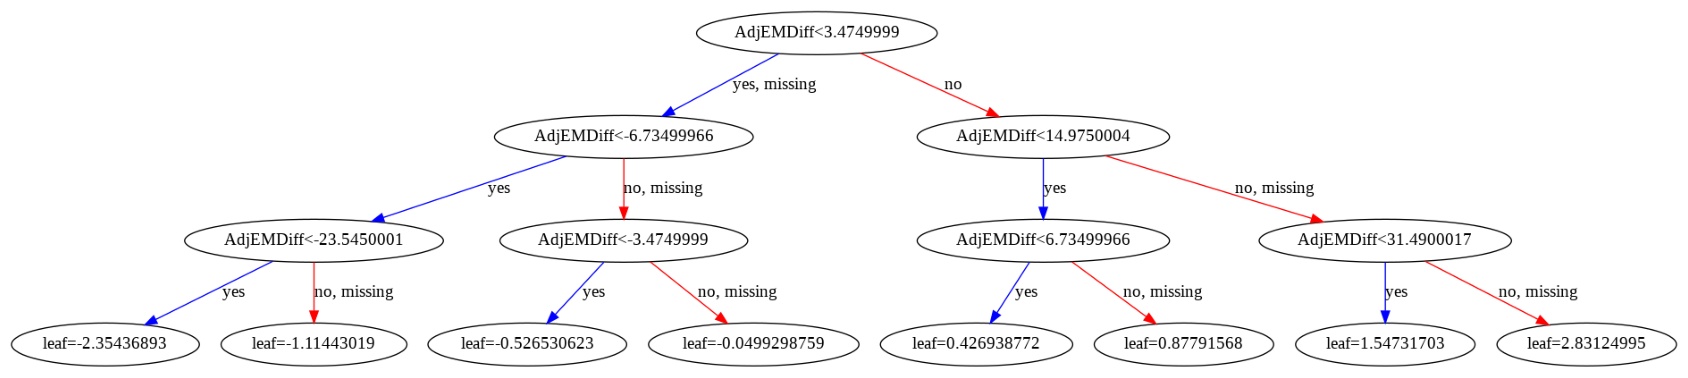

In [98]:
visualize_tree("ScoreDiff", xgboost.XGBRegressor(objective='reg:squarederror'))

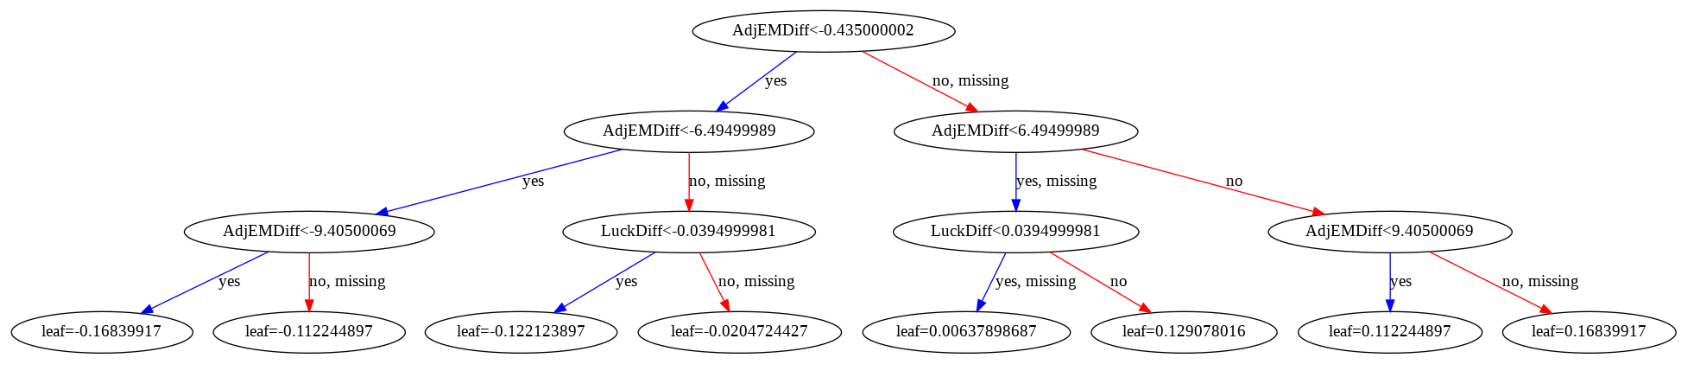

In [94]:
visualize_tree("WinA", xgboost.XGBClassifier(objective='binary:logistic'))